In [2]:
!pip install kagglehub


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Xử lí ảnh trước


### Bước 1 : tải tập dữ liệu


In [6]:
import kagglehub
#https://www.kaggle.com/datasets/sshikamaru/fruit-recognition
# Download latest version
path = kagglehub.dataset_download("sshikamaru/fruit-recognition")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\FPT 2633\.cache\kagglehub\datasets\sshikamaru\fruit-recognition\versions\2


### Code tiền xử lí ảnh

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os # Import os module to remove file

def load_image(image_path):
    """
    Đọc ảnh từ đường dẫn đã cho.

    Parameters:
    - image_path (str): Đường dẫn đến file ảnh.

    Returns:
    - image (numpy.ndarray): Ảnh đã được đọc dưới dạng mảng NumPy (BGR).
    - None: Nếu không thể đọc ảnh.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Lỗi: Không thể đọc ảnh từ đường dẫn: {image_path}")
    return image
def apply_histogram_equalization(image):
    """
    Cân bằng histogram để tăng độ tương phản của ảnh.
    Hiệu quả với ảnh có độ tương phản thấp.
    """
    # Chuyển đổi sang ảnh xám nếu là ảnh màu
    if len(image.shape) == 3:
        # Chuyển đổi sang không gian màu YCrCb
        ycrcb_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        # Cân bằng histogram cho kênh Y (độ sáng)
        ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
        # Chuyển đổi lại không gian màu BGR
        equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    else:
        equalized_img = cv2.equalizeHist(image)

    return equalized_img
def restore_from_noise(image):
    """
    Khôi phục ảnh bị nhiễu bằng bộ lọc Non-Local Means.
    Đây là một kỹ thuật khôi phục ảnh tiên tiến, loại bỏ nhiễu
    trong khi vẫn giữ được các chi tiết và đường nét.
    """
    if len(image.shape) == 3:
        # Khôi phục ảnh màu
        restored_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    else:
        # Khôi phục ảnh xám
        restored_image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
    return restored_image
def convert_to_grayscale(image):
    """
    Chuyển đổi ảnh từ BGR sang ảnh xám (Grayscale).

    Parameters:
    - image (numpy.ndarray): Ảnh đầu vào (BGR).

    Returns:
    - grayscale_image (numpy.ndarray): Ảnh xám.
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_median_filter(image, kernel_size=5):
    """
    Áp dụng Bộ lọc trung vị (Median Filter) để loại bỏ nhiễu.

    Parameters:
    - image (numpy.ndarray): Ảnh đầu vào (nên là ảnh xám).
    - kernel_size (int): Kích thước của kernel (phải là số lẻ, ví dụ: 3, 5, 7).

    Returns:
    - denoised_image (numpy.ndarray):  ảnh đã được làm giảm nhiễu.
    """
    return cv2.medianBlur(image, kernel_size)

def apply_canny_edge_detection(image, lower_threshold=None, upper_threshold=None):
    """
    Phát hiện biên trong ảnh sử dụng thuật toán Canny.

    Parameters:
    - image (numpy.ndarray): Ảnh đầu vào (nên là ảnh xám, đã giảm nhiễu).
    - lower_threshold (int, optional): Ngưỡng dưới cho Canny.
    - upper_threshold (int, optional): Ngưỡng trên cho Canny.

    Returns:
    - edge_image (numpy.ndarray): Ảnh biên (ảnh nhị phân).
    """
    # Tự động xác định ngưỡng nếu không được cung cấp
    if lower_threshold is None or upper_threshold is None:
        median = np.median(image)
        lower = int(max(0, 0.7 * median))
        upper = int(min(255, 1.3 * median))
    else:
        lower = lower_threshold
        upper = upper_threshold

    return cv2.Canny(image, lower, upper)
def segment_by_thresholding(image):
    """
    Phân vùng ảnh bằng phương pháp ngưỡng Otsu.
    Tự động tìm ngưỡng tối ưu để tách đối tượng và nền.
    """
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Áp dụng ngưỡng Otsu
    _, segmented_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return segmented_image

def apply_morphological_opening(image, kernel_size=(3, 3), iterations=1):
    """
    Áp dụng phép Mở (Morphological Opening) để loại bỏ nhiễu nhỏ và làm mịn biên.

    Parameters:
    - image (numpy.ndarray): Ảnh đầu vào (thường là ảnh biên).
    - kernel_size (tuple): Kích thước kernel.
    - iterations (int): Số lần lặp lại phép toán.

    Returns:
    - opened_image (numpy.ndarray): Ảnh sau khi áp dụng phép mở.
    """
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=iterations)

def apply_morphological_closing(image, kernel_size=(3, 3), iterations=1):
    """
    Áp dụng phép Đóng (Morphological Closing) để kết nối các đối tượng và lấp đầy lỗ hổng.

    Parameters:
    - image (numpy.ndarray): Ảnh đầu vào.
    - kernel_size (tuple): Kích thước kernel.
    - iterations (int): Số lần lặp lại phép toán.

    Returns:
    - closed_image (numpy.ndarray): Ảnh sau khi áp dụng phép đóng.
    """
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=iterations)

def extract_boundary(image, kernel_size=(3, 3)):
    """
    Tách biên của đối tượng từ ảnh nhị phân.

    Parameters:
    - image (numpy.ndarray): Ảnh nhị phân đầu vào.
    - kernel_size (tuple): Kích thước kernel dùng cho phép xói mòn (erosion).

    Returns:
    - boundary_image (numpy.ndarray): Ảnh chỉ chứa đường biên.
    """
    kernel = np.ones(kernel_size, np.uint8)
    eroded_image = cv2.erode(image, kernel)
    return cv2.subtract(image, eroded_image)

def display_processing_steps(original_image, steps):
    """
    Hiển thị ảnh gốc và kết quả của từng bước xử lý.

    Parameters:
    - original_image (numpy.ndarray): Ảnh gốc.
    - steps (dict): Một dictionary chứa tên và kết quả của các bước.
    """
    num_steps = len(steps)
    plt.figure(figsize=(15, 10))

    # Hiển thị ảnh gốc
    plt.subplot(2, 4, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('1. Ảnh gốc')
    plt.axis('off')

    # Hiển thị các bước xử lý
    for i, (title, img) in enumerate(steps.items()):
        plt.subplot(2, 4, i + 2)
        cmap = 'gray' if len(img.shape) == 2 else None
        plt.imshow(img, cmap=cmap)
        plt.title(f'{i + 2}. {title}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def full_preprocessing_pipeline(image_path, display_steps=True):
    """
    Thực hiện toàn bộ quy trình tiền xử lý ảnh bằng cách gọi các hàm riêng lẻ.

    Parameters:
    - image_path (str): Đường dẫn đến file ảnh.
    - display_steps (bool): Có hiển thị các bước xử lý hay không.

    Returns:
    - grayscale_image (numpy.ndarray): Ảnh xám đã được xử lý.
    - final_image (numpy.ndarray): Ảnh đã được xử lý cuối cùng, sẵn sàng cho CNN.
    - None: Nếu có lỗi xảy ra.
    """
    # Bước 0: Đọc ảnh
    original_image = load_image(image_path)
    if original_image is None:
        return None, None # Return two Nones if image loading fails
    original_image = cv2.resize(original_image, (100, 100))
    processed_results = {}

    # I. Làm sạch ảnh và Tăng cường chất lượng

    # 1. Chuyển ảnh xám
    grayscale_image = convert_to_grayscale(original_image)
    processed_results['Ảnh xám'] = grayscale_image
    #  Cân bằng histogram
    histogram_img = apply_histogram_equalization(grayscale_image)
    processed_results['Cân bằng histogram'] = histogram_img

    # 2. Loại bỏ nhiễu bằng Median Filter
    denoised_image = apply_median_filter(grayscale_image)
    processed_results['Loại bỏ nhiễu (Median)'] = denoised_image

    # II. Tách đối tượng (Segmentation)

    # 3. Phát hiện biên bằng Canny
    edge_image = apply_canny_edge_detection(denoised_image)
    processed_results['Phát hiện biên (Canny)'] = edge_image

    otsu_img = segment_by_thresholding(grayscale_image)
    processed_results['Phương pháp otsu'] = otsu_img

    # 5c. Tách biên (Boundary Extraction)
    # final_image = extract_boundary(edge_image)
    processed_results['Ảnh đầu vào cho CNN'] = edge_image

    if display_steps:
        display_processing_steps(original_image, processed_results)

    return grayscale_image, edge_image

    # Đầu ra là ảnh dạng (height , with , 2 )

Load ảnh từ tập dữ liệu lên


In [ ]:
import os

dataset_directory = "/kaggle/input/fruit-recognition/train/train"
# '/root/.cache/kagglehub/datasets/sshikamaru/fruit-recognition/versions/2/train/train/' # Corrected path
image_extensions = ('.jpg', '.png', '.jpeg', '.gif', '.bmp', '.tiff')

image_files = []
for root, _, files in os.walk(dataset_directory):
    for file in files:
        if file.lower().endswith(image_extensions):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} image files.")
# Display the first 5 image files found for verification
# print(image_files.shape)
print("First 5 image files:")
for i, img_file in enumerate(image_files[:5]):
    print(f"- {img_file}")

Found 16854 image files.
First 5 image files:
- /kaggle/input/fruit-recognition/train/train/Orange/Orange_398.jpg
- /kaggle/input/fruit-recognition/train/train/Orange/Orange_20.jpg
- /kaggle/input/fruit-recognition/train/train/Orange/Orange_337.jpg
- /kaggle/input/fruit-recognition/train/train/Orange/Orange_190.jpg
- /kaggle/input/fruit-recognition/train/train/Orange/Orange_456.jpg


### Tiền xử lý toàn bộ tập dữ liệu và lưu dưới dạng 2 kênh cho CNN

Bắt đầu tiền xử lý và chuyển đổi tất cả 16854 ảnh sang định dạng 2 kênh...
Đã xử lý và lưu ảnh 1000/16854: preprocessed_two_channel_dataset/Tomato_737_2channel.npy
Đã xử lý và lưu ảnh 2000/16854: preprocessed_two_channel_dataset/Cucumber Ripe_247_2channel.npy
Đã xử lý và lưu ảnh 3000/16854: preprocessed_two_channel_dataset/Pomegranate_216_2channel.npy
Đã xử lý và lưu ảnh 4000/16854: preprocessed_two_channel_dataset/Pineapple_426_2channel.npy
Đã xử lý và lưu ảnh 5000/16854: preprocessed_two_channel_dataset/Kiwi_459_2channel.npy
Đã xử lý và lưu ảnh 6000/16854: preprocessed_two_channel_dataset/Apple Braeburn_61_2channel.npy
Đã xử lý và lưu ảnh 7000/16854: preprocessed_two_channel_dataset/Pear_331_2channel.npy
Đã xử lý và lưu ảnh 8000/16854: preprocessed_two_channel_dataset/Strawberry_158_2channel.npy
Đã xử lý và lưu ảnh 9000/16854: preprocessed_two_channel_dataset/Grape Blue_753_2channel.npy
Đã xử lý và lưu ảnh 10000/16854: preprocessed_two_channel_dataset/Apricot_144_2channel.npy
Đã xử l

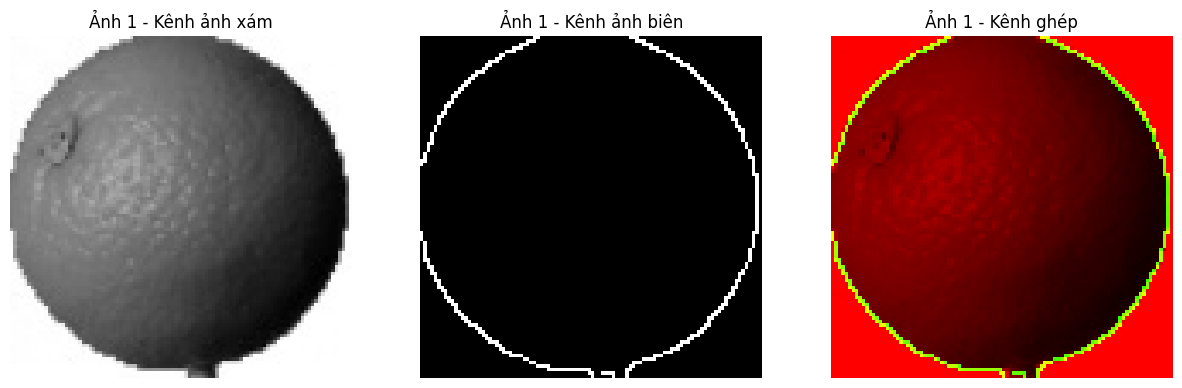

--- Ảnh 2 ---
Đường dẫn gốc: /kaggle/input/fruit-recognition/train/train/Orange/Orange_20.jpg
Đường dẫn file .npy đã lưu: preprocessed_two_channel_dataset/Orange_20_2channel.npy
Kích thước ảnh đã xử lý: (100, 100, 2)


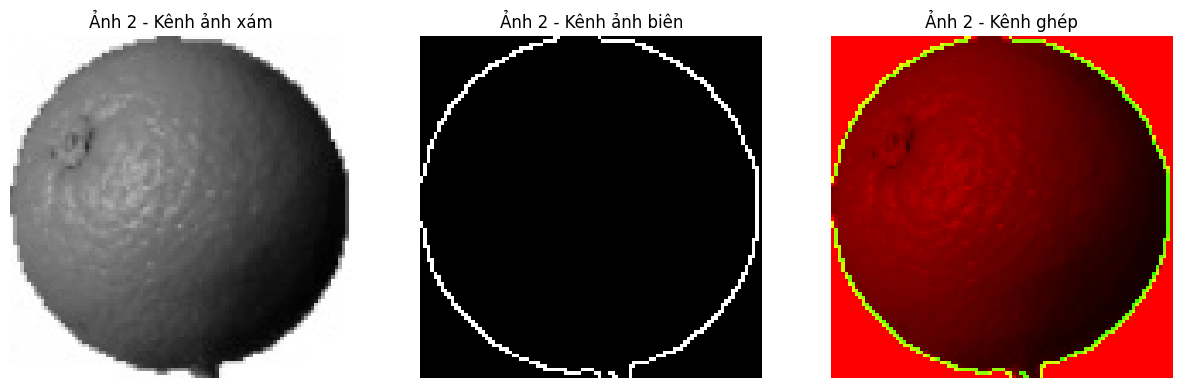

--- Ảnh 3 ---
Đường dẫn gốc: /kaggle/input/fruit-recognition/train/train/Orange/Orange_337.jpg
Đường dẫn file .npy đã lưu: preprocessed_two_channel_dataset/Orange_337_2channel.npy
Kích thước ảnh đã xử lý: (100, 100, 2)


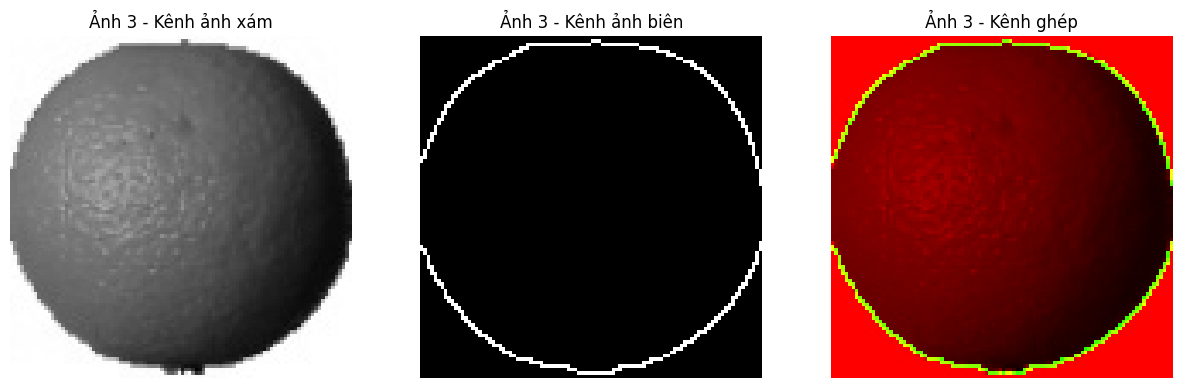

--- Ảnh 4 ---
Đường dẫn gốc: /kaggle/input/fruit-recognition/train/train/Orange/Orange_190.jpg
Đường dẫn file .npy đã lưu: preprocessed_two_channel_dataset/Orange_190_2channel.npy
Kích thước ảnh đã xử lý: (100, 100, 2)


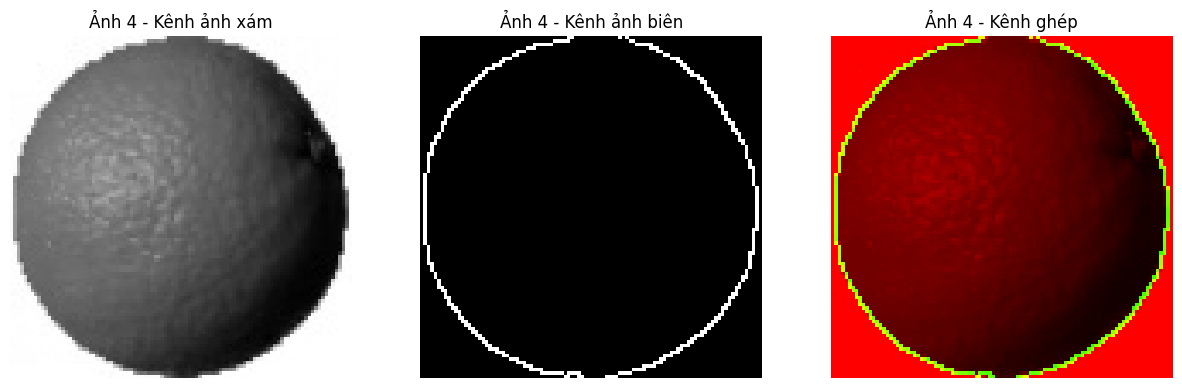

--- Ảnh 5 ---
Đường dẫn gốc: /kaggle/input/fruit-recognition/train/train/Orange/Orange_456.jpg
Đường dẫn file .npy đã lưu: preprocessed_two_channel_dataset/Orange_456_2channel.npy
Kích thước ảnh đã xử lý: (100, 100, 2)


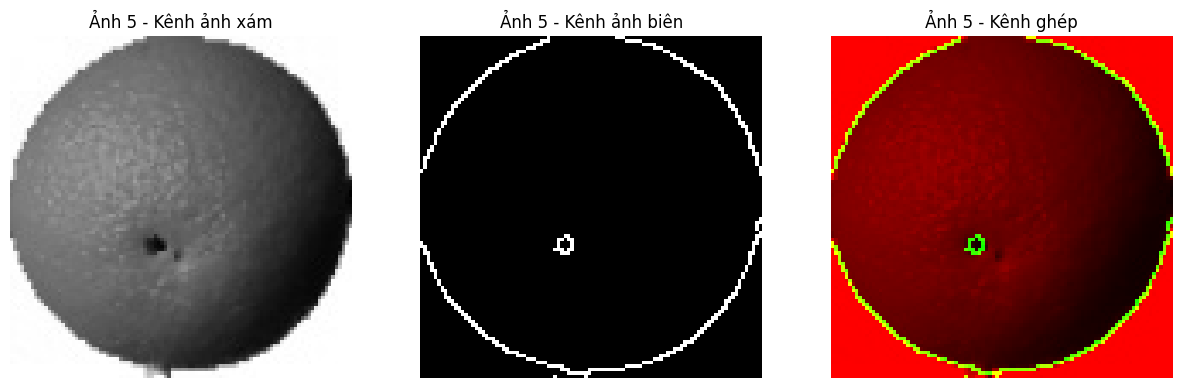

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define output directory for 2-channel processed data
output_two_channel_dir = 'preprocessed_two_channel_dataset'
if not os.path.exists(output_two_channel_dir):
    os.makedirs(output_two_channel_dir)
    print(f"Đã tạo thư mục: {output_two_channel_dir}")

# Desired input size for CNN model (from your model definition)
IMG_HEIGHT, IMG_WIDTH = 100, 100

processed_data_for_cnn = []

print(f"Bắt đầu tiền xử lý và chuyển đổi tất cả {len(image_files)} ảnh sang định dạng 2 kênh...")

for i, img_path in enumerate(image_files):
    # 1. Get grayscale and edge images using the pipeline
    grayscale_img, edge_img = full_preprocessing_pipeline(img_path, display_steps=False)

    if grayscale_img is not None and edge_img is not None:
        # Resize to CNN input dimensions
        # grayscale_resized = cv2.resize(grayscale_img, (IMG_WIDTH, IMG_HEIGHT))
        # edge_resized = cv2.resize(edge_img, (IMG_WIDTH, IMG_HEIGHT))

        # Expand dimensions to (height, width, 1)
        grayscale_chan = np.expand_dims(grayscale_img, axis=-1)
        edge_chan = np.expand_dims(edge_img, axis=-1)

        # Concatenate to form a (height, width, 2) array
        combined_two_channel_img = np.concatenate([grayscale_chan, edge_chan], axis=-1)

        # Extract original filename for saving
        base_name = os.path.basename(img_path)
        file_name_without_ext = os.path.splitext(base_name)[0]
        save_path_npy = os.path.join(output_two_channel_dir, f"{file_name_without_ext}_2channel.npy")

        # Save the 2-channel numpy array
        np.save(save_path_npy, combined_two_channel_img)

        processed_data_for_cnn.append((img_path, save_path_npy)) # Store original path and saved npy path

        if (i + 1) % 1000 == 0 or i == len(image_files) - 1:
            print(f"Đã xử lý và lưu ảnh {i+1}/{len(image_files)}: {save_path_npy}")
    else:
        print(f"Thất bại khi tiền xử lý ảnh: {img_path}")

print("Hoàn tất việc tiền xử lý và lưu trữ tất cả ảnh vào định dạng 2 kênh.")
print(f"Tổng số ảnh 2 kênh đã lưu: {len(processed_data_for_cnn)}")

# Display first 5 preprocessed 2-channel images
print("\nHiển thị 5 ảnh đã xử lý đầu tiên (2 kênh):")
for i, (original_path, npy_path) in enumerate(processed_data_for_cnn[:5]):
    print(f"--- Ảnh {i+1} ---")
    print(f"Đường dẫn gốc: {original_path}")
    print(f"Đường dẫn file .npy đã lưu: {npy_path}")

    loaded_img = np.load(npy_path)
    print(f"Kích thước ảnh đã xử lý: {loaded_img.shape}")

    plt.figure(figsize=(15, 5))

    # Grayscale Channel
    plt.subplot(1, 3, 1)
    plt.imshow(loaded_img[:, :, 0], cmap='gray')
    plt.title(f'Ảnh {i+1} - Kênh ảnh xám')
    plt.axis('off')

    # Edge Channel
    plt.subplot(1, 3, 2)
    plt.imshow(loaded_img[:, :, 1], cmap='gray')
    plt.title(f'Ảnh {i+1} - Kênh ảnh biên')
    plt.axis('off')

    # Combined for display (Grayscale to Red, Edge to Green)
    display_combined = np.zeros((loaded_img.shape[0], loaded_img.shape[1], 3), dtype=np.uint8)
    display_combined[:, :, 0] = loaded_img[:, :, 0] # Grayscale to Red
    display_combined[:, :, 1] = loaded_img[:, :, 1] # Edge to Green

    plt.subplot(1, 3, 3)
    plt.imshow(display_combined)
    plt.title(f'Ảnh {i+1} - Kênh ghép')
    plt.axis('off')

    plt.show()

### HUấn luyện mô hình


Đang tải dữ liệu từ các file .npy...
Kích thước dữ liệu đầu vào (X): (16854, 100, 100, 2)
Số lượng nhãn (y): 16854
Các loại quả đã tìm thấy: ['Apple Braeburn' 'Apple Granny Smith' 'Apricot' 'Avocado' 'Banana'
 'Blueberry' 'Cactus fruit' 'Cantaloupe' 'Cherry' 'Clementine' 'Corn'
 'Cucumber Ripe' 'Grape Blue' 'Kiwi' 'Lemon' 'Limes' 'Mango' 'Onion White'
 'Orange' 'Papaya' 'Passion Fruit' 'Peach' 'Pear' 'Pepper Green'
 'Pepper Red' 'Pineapple' 'Plum' 'Pomegranate' 'Potato Red' 'Raspberry'
 'Strawberry' 'Tomato' 'Watermelon']
Training set: (13483, 100, 100, 2)
Test set: (3371, 100, 100, 2)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,143,873 (19.62 MB)

 Trainable params: 5,143,681 (19.62 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.1701 - loss: 3.8749 - val_accuracy: 0.2949 - val_loss: 2.7156
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2490 - loss: 2.5466 - val_accuracy: 0.4482 - val_loss: 1.7941
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2781 - loss: 2.3857 - val_accuracy: 0.5165 - val_loss: 1.5568
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3122 - loss: 2.2212 - val_accuracy: 0.5702 - val_loss: 1.4103
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3610 - loss: 2.0537 - val_accuracy: 0.6434 - val_loss: 1.2081
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4378 - loss: 1.8404 - val_accuracy: 0.7677 - val_loss: 0.7849
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4657 - loss: 1.6742 - val_accuracy: 0.7579 - val_loss: 0.8363
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5210 - loss: 1.4983 - val_acc

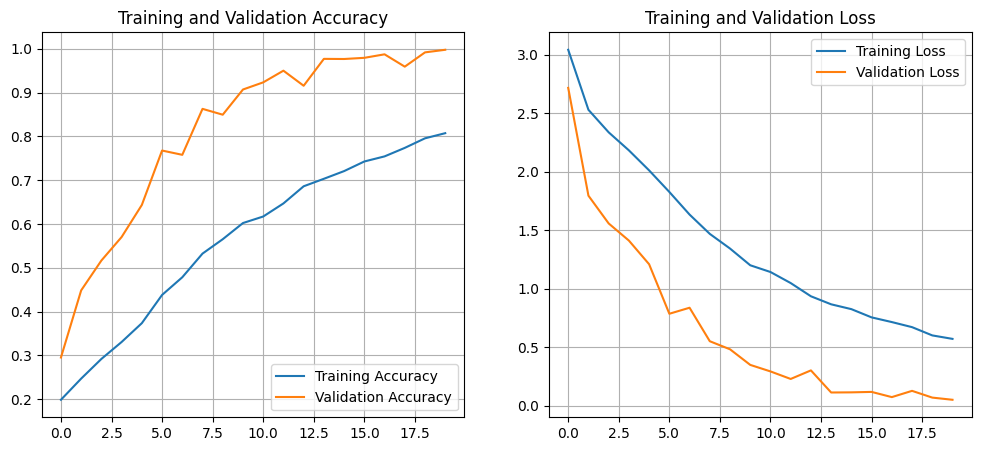

Đã lưu mô hình thành công!


In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. Load dữ liệu và nhãn
X = []
y = []

print("Đang tải dữ liệu từ các file .npy...")

# processed_data_for_cnn là list chứa [(original_path, npy_path), ...] từ code trước của bạn
# Nếu bạn đã chạy xong code trước, biến này vẫn còn trong bộ nhớ.
for original_path, npy_path in processed_data_for_cnn:
    try:
        # Load ảnh 2 kênh
        data = np.load(npy_path)
        X.append(data)

        # Lấy nhãn từ tên thư mục cha (ví dụ: .../Apple/apple01.jpg -> label: Apple)
        label = os.path.basename(os.path.dirname(original_path))
        y.append(label)
    except Exception as e:
        print(f"Lỗi khi đọc file {npy_path}: {e}")

X = np.array(X)
y = np.array(y)

# Chuẩn hóa dữ liệu về khoảng [0, 1] để mô hình học tốt hơn
X = X.astype('float32') / 255.0

print(f"Kích thước dữ liệu đầu vào (X): {X.shape}") # (Số lượng ảnh, 100, 100, 2)
print(f"Số lượng nhãn (y): {len(y)}")

# 2. Mã hóa nhãn (Label Encoding)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded) # One-hot encoding
num_classes = len(le.classes_)

print("Các loại quả đã tìm thấy:", le.classes_)

# 3. Chia tập train, validation và test (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2

# Data Augmentation tùy chỉnh cho ảnh 2 kênh
def augment_image_2channel(image):
    """
    Augment ảnh 2 kênh (grayscale + edge)
    Áp dụng cùng transformation cho cả 2 kênh để giữ tính nhất quán
    image shape: (100, 100, 2)
    """
    h, w, c = image.shape
    center = (w // 2, h // 2)
    augmented = image.copy()
    
    # Random horizontal flip (áp dụng cho cả 2 kênh cùng lúc)
    if np.random.random() > 0.5:
        augmented = np.flip(augmented, axis=1)
    
    # Combine transformations vào một matrix để tránh mất thông tin
    # Random rotation
    angle = np.random.uniform(-15, 15)
    
    # Random shift
    tx = np.random.uniform(-0.1, 0.1) * w
    ty = np.random.uniform(-0.1, 0.1) * h
    
    # Random zoom
    zoom = np.random.uniform(0.9, 1.1)
    
    # Tạo combined transformation matrix
    M = cv2.getRotationMatrix2D(center, angle, zoom)
    M[0, 2] += tx
    M[1, 2] += ty
    
    # Áp dụng transformation cho từng kênh
    for channel in range(c):
        augmented[:, :, channel] = cv2.warpAffine(
            augmented[:, :, channel], 
            M, 
            (w, h), 
            borderMode=cv2.BORDER_REPLICATE
        )
    
    return augmented

# Tạo augmented data
def create_augmented_dataset(X_train, y_train, augment_factor=1):
    """
    Tạo thêm dữ liệu bằng augmentation
    augment_factor: số lần augment mỗi ảnh (1 = tăng gấp đôi)
    """
    X_aug = []
    y_aug = []
    
    for i in range(len(X_train)):
        # Thêm ảnh gốc
        X_aug.append(X_train[i])
        y_aug.append(y_train[i])
        
        # Thêm ảnh augmented
        for _ in range(augment_factor):
            aug_img = augment_image_2channel(X_train[i])
            X_aug.append(aug_img)
            y_aug.append(y_train[i])
    
    return np.array(X_aug), np.array(y_aug)

print("Tạo augmented dataset...")
X_train_aug, y_train_aug = create_augmented_dataset(X_train, y_train, augment_factor=1)
print(f"Training set sau augmentation: {X_train_aug.shape}")

def build_cnn_model_improved(input_shape, num_classes):
    """
    Model được cải thiện để giảm overfitting:
    - Tăng dropout rates
    - Thêm L2 regularization
    - Thêm một Conv block với dropout cao hơn
    """
    model = Sequential()

    # Input layer: Chú ý input_shape là (100, 100, 2)
    model.add(Input(shape=input_shape))

    # Block 1: Trích xuất đặc trưng cấp thấp
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', 
                     kernel_regularizer=l2(0.0001)))  # Thêm L2 regularization
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))  # Tăng từ 0 lên 0.3

    # Block 2: Trích xuất đặc trưng cấp trung
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))  # Tăng từ 0.25 lên 0.4

    # Block 3: Trích xuất đặc trưng cấp cao (BỎ COMMENT để thêm block này)
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))  # Dropout cao cho block cuối

    # Flatten: Duỗi thẳng để đưa vào mạng nơ-ron đầy đủ (Dense)
    model.add(Flatten())

    # Fully Connected Layers (Phân lớp)
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.6))  # Tăng từ 0.5 lên 0.6
    
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))  # Thêm layer Dense nhỏ hơn
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax')) # Output layer

    return model

# Khởi tạo model
model = build_cnn_model_improved((100, 100, 2), num_classes)
model.summary()

# Compile model với learning rate thấp hơn
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)  # Giảm learning rate từ default (0.001) xuống 0.0001

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks để giảm overfitting
callbacks = [
    # Early Stopping: Dừng training nếu validation loss không cải thiện
    EarlyStopping(
        monitor='val_loss',
        patience=5,  # Đợi 5 epochs không cải thiện thì dừng
        restore_best_weights=True,  # Khôi phục weights tốt nhất
        verbose=1
    ),
    # Reduce Learning Rate: Giảm learning rate nếu không cải thiện
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Giảm LR xuống 50%
        patience=3,  # Đợi 3 epochs
        min_lr=0.00001,  # LR tối thiểu
        verbose=1
    ),
    # Model Checkpoint: Lưu model tốt nhất
    ModelCheckpoint(
        'best_model_2channel.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

import matplotlib.pyplot as plt

# Huấn luyện với data augmentation
EPOCHS = 50  # Tăng epochs vì có early stopping
BATCH_SIZE = 32

print("Bắt đầu training với các cải tiến chống overfitting...")
print("- Data Augmentation")
print("- Early Stopping")
print("- Learning Rate Scheduling")
print("- L2 Regularization")
print("- Tăng Dropout rates")
print("- Validation set riêng biệt\n")

history = model.fit(
    X_train_aug, y_train_aug,  # Sử dụng augmented data
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),  # Sử dụng validation set riêng
    callbacks=callbacks,
    verbose=1
)

# Load model tốt nhất
model.load_weights('best_model_2channel.h5')
print("\nĐã load model tốt nhất dựa trên validation accuracy!")

# Đánh giá trên test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- Vẽ biểu đồ Accuracy và Loss ---
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))

    # Biểu đồ Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)

    # Biểu đồ Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Biểu đồ so sánh gap (overfitting indicator)
    plt.subplot(1, 3, 3)
    acc_gap = [a - v for a, v in zip(acc, val_acc)]
    loss_gap = [v - l for l, v in zip(loss, val_loss)]
    plt.plot(epochs_range, acc_gap, label='Accuracy Gap (Train - Val)', linewidth=2, color='red')
    plt.plot(epochs_range, loss_gap, label='Loss Gap (Val - Train)', linewidth=2, color='blue')
    plt.legend()
    plt.title('Overfitting Indicator', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Gap')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Lưu model cuối cùng
model.save('fruit_recognition_cnn_2channel.h5')
print("\n✅ Đã lưu mô hình thành công!")
print(f"📊 Final Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"📊 Final Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
import pickle

# Lưu LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Đã lưu LabelEncoder vào file 'label_encoder.pkl'")

Đã lưu LabelEncoder vào file 'label_encoder.pkl'


Đang dự đoán ảnh: /kaggle/input/fruit-recognition/train/train/Orange/Orange_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


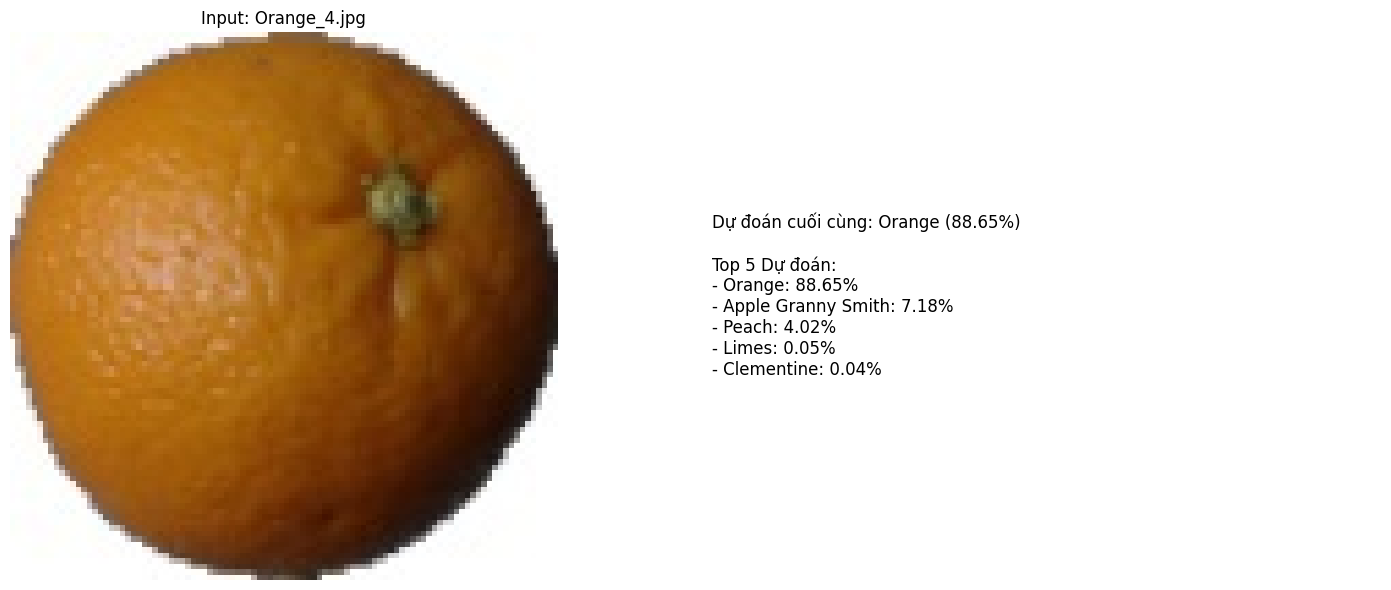

In [ ]:
  def predict_fruit(image_path, model, label_encoder):
    """
    Hàm dự đoán loại quả từ đường dẫn ảnh, hiển thị 5 dự đoán hàng đầu
    và dự đoán cuối cùng (có độ tin cậy cao nhất).
    """
    # 1. Tiền xử lý ảnh (Sử dụng lại pipeline của bạn)
    grayscale_img, edge_img = full_preprocessing_pipeline(image_path, display_steps=False) # display_steps=False để tránh hiển thị quá nhiều biểu đồ

    if grayscale_img is None:
        print("Không thể đọc ảnh.")
        return

    # 2. Resize (đảm bảo đúng kích thước 100x100)
    if grayscale_img.shape != (100, 100):
        grayscale_img = cv2.resize(grayscale_img, (100, 100))
        edge_img = cv2.resize(edge_img, (100, 100))

    # 3. Tạo định dạng 2 kênh (Height, Width, 2)
    grayscale_chan = np.expand_dims(grayscale_img, axis=-1)
    edge_chan = np.expand_dims(edge_img, axis=-1)
    input_img = np.concatenate([grayscale_chan, edge_chan], axis=-1)

    # 4. Chuẩn hóa (chia 255.0 giống lúc train)
    input_img = input_img.astype('float32') / 255.0

    # 5. Mở rộng chiều batch (1, 100, 100, 2)
    input_batch = np.expand_dims(input_img, axis=0)

    # 6. Dự đoán
    predictions = model.predict(input_batch)
    probabilities = predictions[0] # Lấy mảng xác suất cho một ảnh đầu vào

    # Sắp xếp các xác suất và lấy chỉ số của 5 dự đoán hàng đầu
    top_5_indices = np.argsort(probabilities)[::-1][:5]
    top_5_probabilities = probabilities[top_5_indices]

    # Lấy tên lớp tương ứng cho 5 dự đoán hàng đầu
    top_5_labels = label_encoder.inverse_transform(top_5_indices)

    # Dự đoán cuối cùng (có độ tin cậy cao nhất)
    predicted_class_idx = np.argmax(probabilities)
    predicted_label = label_encoder.inverse_transform([predicted_class_idx])[0]
    confidence = np.max(probabilities) * 100

    # 7. Hiển thị kết quả
    plt.figure(figsize=(15, 6))

    # Hiển thị ảnh gốc (đọc lại để hiển thị màu)
    original_bgr = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title(f"Input: {os.path.basename(image_path)}")
    plt.axis('off')

    # Hiển thị kết quả dự đoán
    plt.subplot(1, 2, 2)
    display_text = f"Dự đoán cuối cùng: {predicted_label} ({confidence:.2f}%)\n\nTop 5 Dự đoán:\n"
    for i in range(len(top_5_labels)):
        display_text += f"- {top_5_labels[i]}: {top_5_probabilities[i]*100:.2f}%\n"

    plt.text(0.1, 0.5, display_text, fontsize=12, verticalalignment='center', horizontalalignment='left')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return predicted_label, confidence

# --- CHẠY THỬ NGHIỆM ---
# Lấy một ảnh bất kỳ từ tập test hoặc ảnh ngoài để thử
# Lưu ý: Thay đổi đường dẫn này đến ảnh bạn muốn dự đoán
# duong_dan = "/root/.cache/kagglehub/datasets/sshikamaru/fruit-recognition/versions/2/test/test/Apple Braeburn_0.jpg" # Ví dụ ảnh Apple Braeburn
duong_dan = "/kaggle/input/fruit-recognition/train/train/Orange/Orange_4.jpg" # Ví dụ ảnh không phải quả
# duong_dan = "/kaggle/input/fruit-recognition/test/test/0001.jpg"

print(f"Đang dự đoán ảnh: {duong_dan}")

pred_label, conf = predict_fruit(duong_dan, model, le)
